## 复现Boyko2022论文里的第一个例子

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# 生成Axillary process, 其中u(t)是U的第一个分量
Tc = 1.0  # cut-off frenquency
dt = 1e-6  # time-step
T = 1.0  
n_steps = int(T / dt) 



# 定义矩阵A_D
A = torch.tensor([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 2.61, 3.41, 2.61]
], dtype=torch.float32)

# 定义噪声矩阵b (只在(4,4)位置为1)
B = torch.zeros(4, 4)
B[3, 3] = 1.0

sqrt_dt = torch.sqrt(torch.tensor(dt)) #提前计算好随机方差项，不用每次迭代都计算一次
noise_U = torch.randn((4, n_steps), dtype=A.dtype, device=A.device)

# 初始化状态
U = torch.zeros(4)  # 初始状态 [u1, u2, u3, u4]

# 存储结果
history = torch.zeros(n_steps + 1, 4)
history[0] = U.clone()

# Euler-Maruyama模拟
for i in range(n_steps):
    # 确定性部分
    deterministic = (-1/Tc) * A @ U * dt
    
    # 随机部分 - 仅在第4个分量添加噪声
    stochastic = B @ noise_U[:,i] * sqrt_dt
    
    # 更新状态
    U = U + deterministic + stochastic
    
    # 存储结果
    history[i+1] = U.clone()



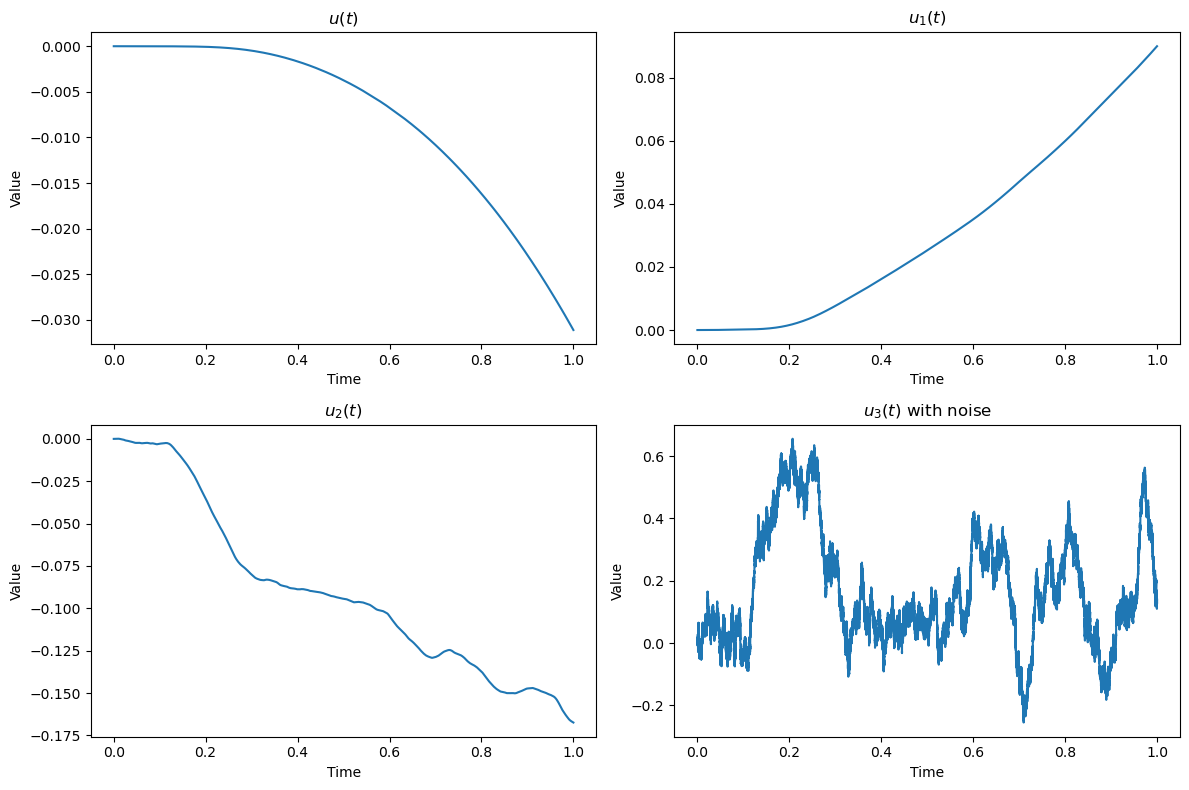

In [3]:
# 可视化U的各个分量, 可以验证U的定义就是平滑化第一个分量u(t), 其余分量可以看作不同阶的导数
time = torch.linspace(0, T, n_steps + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time, history[:, 0])
plt.title('$u(t)$')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(2, 2, 2)
plt.plot(time, history[:, 1])
plt.title('$u_1(t)$')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
plt.plot(time, history[:, 2])
plt.title('$u_2(t)$')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
plt.plot(time, history[:, 3])
plt.title('$u_3(t)$ with noise')
plt.xlabel('Time')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

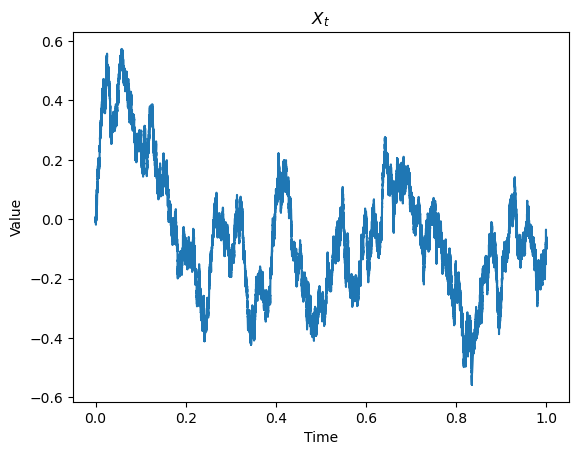

In [4]:
# 生成X_t
ut = history[:, 0].clone()
theta_1 = 2*ut
theta_2 = 1/((ut-1)**4 + 0.1)
theta_3 = (ut-1)**2 + 0.1

X = torch.zeros((n_steps + 1, 1),  dtype=ut.dtype, device=ut.device) 

sqrt_dt = torch.sqrt(torch.tensor(dt, dtype=ut.dtype, device=ut.device))
    
# 使用 torch.randn 一次性生成随机数
noise_X = torch.randn((n_steps, 1), dtype=ut.dtype, device=ut.device)

for i in range(n_steps):
        drift_term = (theta_1[i] - theta_2[i] * X[i]) * dt
        diffusion_term = theta_3[i] * noise_X[i] * sqrt_dt
        
        X[i+1] = X[i] + drift_term + diffusion_term

plt.plot(time,X)
plt.title('$X_t$')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()